In [1]:
# import all necessory libraries
import re
import numpy as np 
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

### Import Data

In [3]:
user_eng_df = pd.read_csv('data/takehome_user_engagement.csv')
users_df = pd.read_csv('data/takehome_users.csv', encoding='latin-1') #would throw error with no encoding

In [4]:
user_eng_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [504]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [505]:
print(users_df.shape)
print(users_df.isnull().sum())

(12000, 10)
object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64


### Merge Dataframe

In [506]:
# combine two dataframe using outer join
data_df = user_eng_df.merge(users_df, left_on='user_id', right_on='object_id', how='outer')

# Remove duplicate/unnecessary columns. 'visited' only has 1 for an entry, trivial column.
del data_df['object_id'], data_df['visited']

### Data Analysis

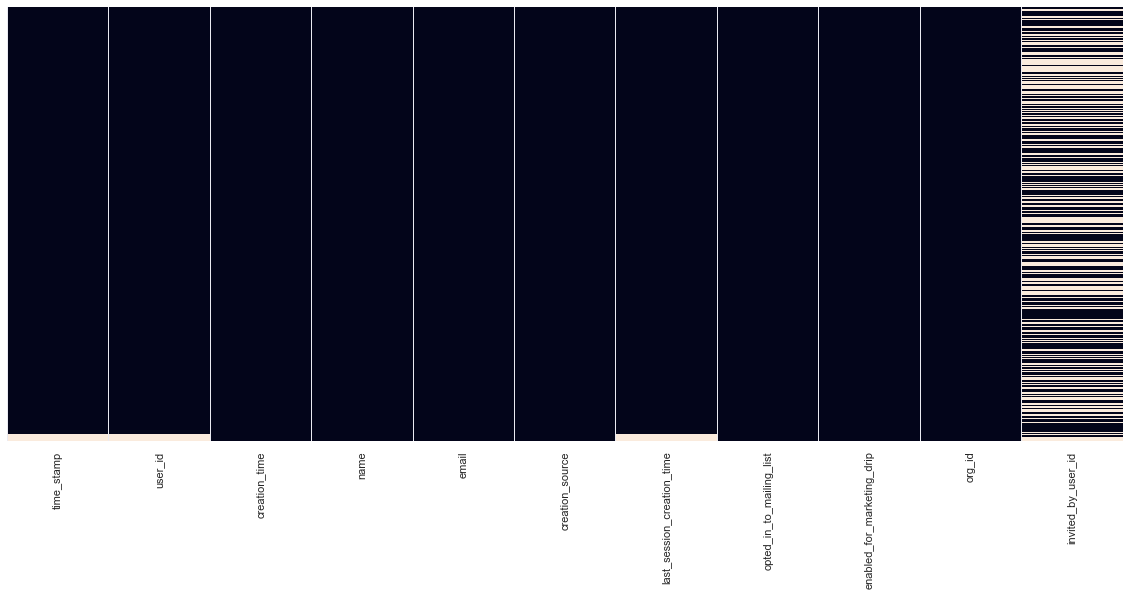

In [507]:
# plot heatmap to visualize missing values
plt.figure(figsize=(20,8))
sns.heatmap(data_df.isnull(),yticklabels=False,cbar=False)
plt.show()

- `invited_by_user_id has most number of null values, therefore we will remove that column.` 

In [508]:
print(data_df.shape)
print(data_df.isnull().sum())

(211094, 11)
time_stamp                     3177
user_id                        3177
creation_time                     0
name                              0
email                             0
creation_source                   0
last_session_creation_time     3177
opted_in_to_mailing_list          0
enabled_for_marketing_drip        0
org_id                            0
invited_by_user_id            92566
dtype: int64


In [509]:
data_df.shape

(211094, 11)

In [510]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211094 entries, 0 to 211093
Data columns (total 11 columns):
time_stamp                    207917 non-null object
user_id                       207917 non-null float64
creation_time                 211094 non-null object
name                          211094 non-null object
email                         211094 non-null object
creation_source               211094 non-null object
last_session_creation_time    207917 non-null float64
opted_in_to_mailing_list      211094 non-null int64
enabled_for_marketing_drip    211094 non-null int64
org_id                        211094 non-null int64
invited_by_user_id            118528 non-null float64
dtypes: float64(3), int64(3), object(5)
memory usage: 19.3+ MB


In [511]:
data_df.describe()

,user_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,207917.000000,2.079170e+05,211094.000000,211094.000000,211094.000000,118528.000000
mean,5913.314197,1.399439e+09,0.257890,0.154344,163.949558,5971.333347
std,3394.941674,8.294017e+06,0.437474,0.361279,121.240661,3248.588044
min,1.000000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3087.000000,1.401045e+09,0.000000,0.000000,60.000000,3269.000000
50%,5682.000000,1.401665e+09,0.000000,0.000000,145.000000,5972.000000
75%,8944.000000,1.401868e+09,1.000000,0.000000,260.000000,8513.000000
max,12000.000000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [512]:
corr_data = data_df.corr()
corr_data

,user_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
user_id,1.000000,-0.012878,-0.040880,-0.029354,-0.033602,0.127236
last_session_creation_time,-0.012878,1.000000,-0.004539,-0.008294,0.029462,0.005599
opted_in_to_mailing_list,-0.040880,-0.004539,1.000000,0.472457,-0.041098,0.013854
enabled_for_marketing_drip,-0.029354,-0.008294,0.472457,1.000000,-0.027600,0.023140
org_id,-0.033602,0.029462,-0.041098,-0.027600,1.000000,-0.104996
invited_by_user_id,0.127236,0.005599,0.013854,0.023140,-0.104996,1.000000


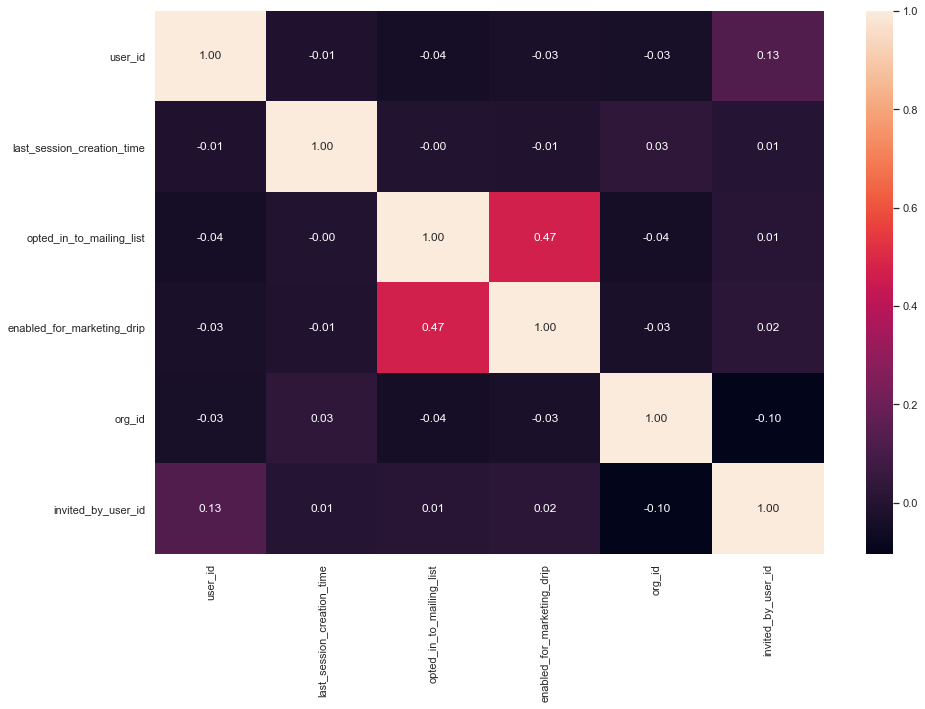

In [513]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.set_context("notebook",font_scale = 1.0, rc = {"lines.linewidth":2.5})
ax = sns.heatmap(corr_data, annot = True, fmt = ".2f")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

### Darta Pre-Processing

In [514]:
data_df['invited_by_user_id'] = data_df['invited_by_user_id'].fillna(0)

# Drop rows of NaN values
data_df = data_df.dropna()

# Correcting Data Types
data_df['user_id'] = data_df['user_id'].astype(int)
data_df['invited_by_user_id'] = data_df['invited_by_user_id'].astype(int)
data_df['creation_time'] = pd.to_datetime(data_df['creation_time'], format='%Y-%m-%d %H:%M:%S')
data_df['time_stamp'] = pd.to_datetime(data_df['time_stamp'], format='%Y-%m-%d %H:%M:%S')

In [515]:
# Initially set all users as not 'adopted' (0 is false, 1 is true).
data_df['active_users'] = 0

# Data of users and how many times each of them have logged in. 
num_logins = data_df['name'].value_counts().values

# Names of users who logged in 3 or more times
valid_users = data_df['name'].value_counts().index[0:len(num_logins[num_logins>=3])]

# Setting a variable to aggregate over
data_df['counter'] = 1
user_labels = []

for idx, user in enumerate(valid_users): 
    user_df = data_df[data_df.name==user]
    # Maximum number of logins in any week for each user
    max_logins = user_df.set_index("time_stamp").resample("7D").sum().dropna()['counter'].max()
    
    if max_logins>=3:
        user_labels.append(1)
    else:
        user_labels.append(0)

# Extracting names of users who are considered 'adopted', and the total num of adopted users
active_users_names = valid_users[np.where(np.array(user_labels)==1)]
num_active_users = len(active_users_names)

# Deleting aggregation counter
del data_df['counter']

# Giving the 'adopted users' their appropriate labels
data_df.loc[data_df['name'].isin(active_users_names), 'active_users'] = 1

# Do the same for the users dataframe
users_df['active_users'] = 0
users_df.loc[users_df['name'].isin(active_users_names), 'active_users'] = 1

In [516]:
#Deleting a bunch of useless data
del data_df['time_stamp'], data_df['name'], data_df['creation_time']
del data_df['last_session_creation_time']
del users_df['creation_time'], users_df['last_session_creation_time']

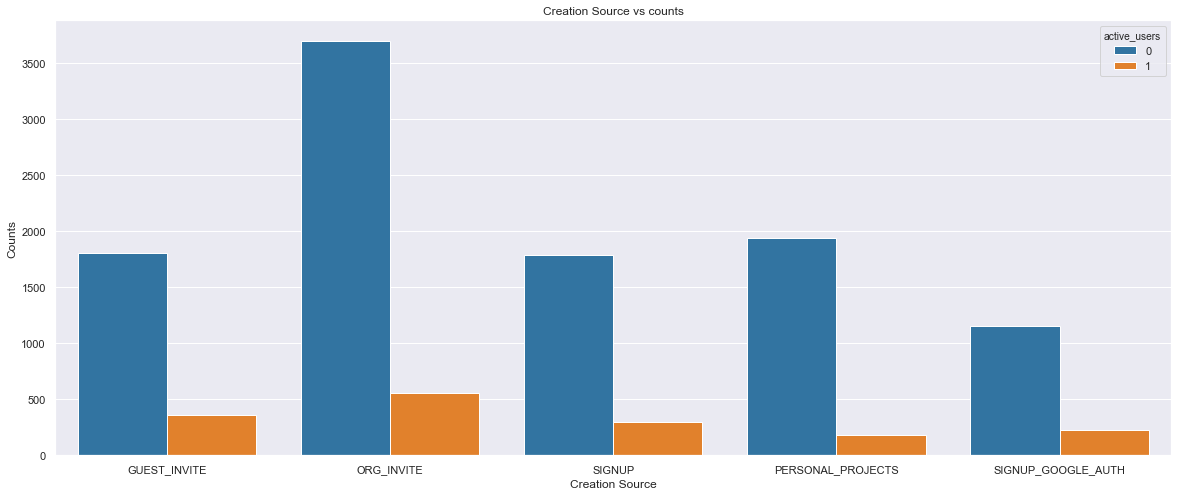

In [517]:
# plot total logins by each hour 
plt.figure(figsize=(20,8))
sns.countplot(x= 'creation_source', hue='active_users',data=users_df)
plt.xlabel('Creation Source')
plt.title('Creation Source vs counts')
plt.ylabel('Counts')
plt.show()

As seen in above countplot, ORG_INVITE and GUEST_INVITE are more active users than any other source.

### One HotEncoding

In [518]:
# One hot encode categorical variables
from collections import Counter
users_df = users_df.join(pd.get_dummies(users_df['creation_source']))

# Set the index as the user IDs.
users_df = users_df.set_index(users_df.object_id)

del users_df['creation_source'], users_df['object_id'], users_df['name'], users_df['email']
del users_df['org_id'], users_df['invited_by_user_id']

X = users_df.drop(['active_users'], axis=1)
y = users_df['active_users']

n_neg, n_pos = (Counter(users_df['active_users'])[0], Counter(users_df['active_users'])[1])

### Building Model

In [519]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [520]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# fit model to training data
XGB_model = XGBClassifier()
XGB_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [521]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)

In [522]:
columns = X_train.columns
smote_X, smote_y = smote.fit_sample(X_train, y_train)
smote_X = pd.DataFrame(data=smote_X,columns=columns )
smote_y= pd.DataFrame(data=smote_y,columns=['active_users'])

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67      2200
           1       0.00      0.00      0.00      2165

    accuracy                           0.50      4365
   macro avg       0.25      0.50      0.34      4365
weighted avg       0.25      0.50      0.34      4365



/Users/suroor/Documents/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


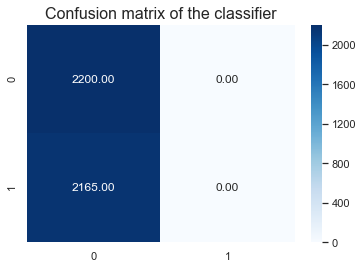

In [523]:
X= smote_X
y= smote_y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


# make predictions for test data
y_pred = XGB_model.predict(X_test)
predictions = [round(value) for value in y_pred]

# Confusion Matrix Heatmap - evaluate predictions
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot = True, fmt = ".2f",cmap=plt.cm.Blues)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion matrix of the classifier',fontsize=16)
print("Classification Report:\n", classification_report(y_test, y_pred))
plt.show()

Text(0, 0.5, 'Feature Importance Score')

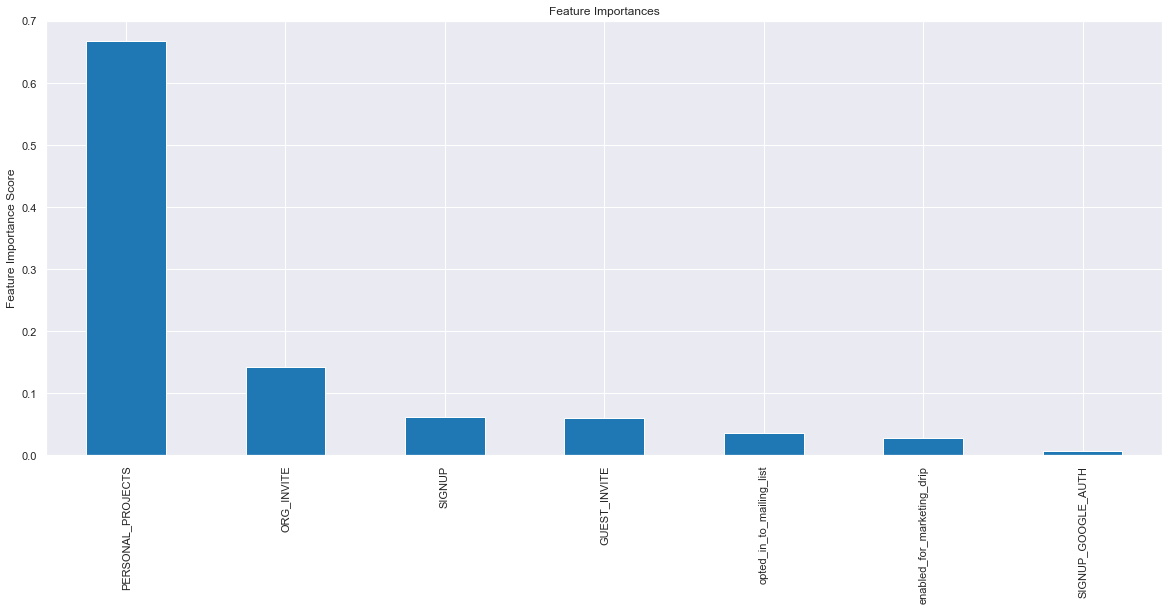

In [524]:
plt.figure(figsize=(20,8))
feat_imp = pd.Series(XGB_model.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

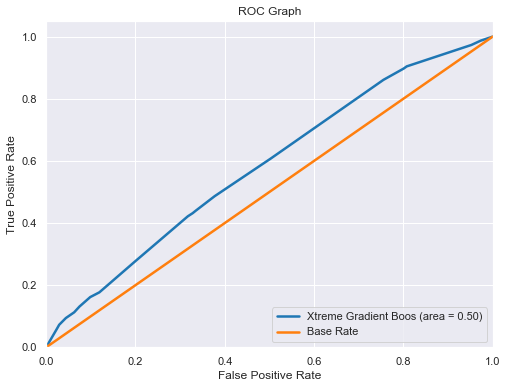

In [525]:
# Create ROC Graph
from sklearn.metrics import roc_curve, roc_auc_score

xgb_roc_auc = roc_auc_score(y_test, XGB_model.predict(X_test))
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, XGB_model.predict_proba(X_test)[:,1])

# Plot Xtreme Gradient Boost ROC
plt.figure(figsize=(8,6))
plt.plot(xgb_fpr, xgb_tpr, label='Xtreme Gradient Boos (area = %0.2f)' % xgb_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

### Conclusions

Users who sign up through invites to personal projects (PERSONAL_PROJECTS) and users who sign up through guest invitations (GUEST_INVITE) are more likely to be 'adopted users'. Model can improved with proper Data cleaning and by applyting further hyper parameter tuning.